### IMPORTS

In [1]:
from Inference.VariationalAE import MeanFieldVariationalAE
from Inference.Variational import MeanFieldVariationalDistribution


In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [5]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [6]:
# load data and make it in proper shape
data_val = torch.load('data/foong_data_validation.pt')
x_data_val = data_val[0].to(device)
y_data_val = data_val[1].to(device)
y_data_val = y_data_val.unsqueeze(-1)

In [7]:
model = nn.Sequential( nn.Linear(1, 4),
                       nn.Tanh(),
                      nn.Linear(4,1)
                     ).to(device)
for params in model.parameters():
    params.requires_grad = False

In [8]:
param_count = get_param(model).shape[0]
param_count

13

In [9]:
VAE = MeanFieldVariationalAE(3*param_count,10*param_count,param_count)
VAE_param_count = get_param(VAE).shape[0]
VAE_param_count

6981

In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
VAE.decoder.apply(init_weights)

Sequential(
  (0): Linear(in_features=39, out_features=130, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=130, out_features=13, bias=True)
)

In [11]:
prior = MeanFieldVariationalDistribution(3*param_count, sigma=0.05, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [12]:
def logprior(x):
    return prior.log_prob(x)

In [13]:
sigma_like=.1

def loglikelihood(theta, x, y, sigma_likeli=sigma_like):
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_likeli],device=device))
    return torch.sum(L).unsqueeze(-1)

In [14]:
def flip_parameters_to_tensors(module):
    attr = []
    while bool(module._parameters):
        attr.append( module._parameters.popitem() )
    setattr(module, 'registered_parameters_name', [])

    for i in attr:
        setattr(module, i[0], torch.zeros(i[1].shape,requires_grad=True))
        module.registered_parameters_name.append(i[0])

    module_name = [k for k,v in module._modules.items()]

    for name in module_name:
        flip_parameters_to_tensors(module._modules[name])

In [15]:
def set_all_parameters(module, theta):
    count = 0  

    for name in module.registered_parameters_name:
        a = count
        b = a + getattr(module, name).numel()
        t = torch.reshape(theta[0,a:b], getattr(module, name).shape)
        setattr(module, name, t)

        count += getattr(module, name).numel()

    module_name = [k for k,v in module._modules.items()]
    for name in module_name:
        count += set_all_parameters(module._modules[name], theta)
    return count

In [16]:
flip_parameters_to_tensors(model)

# KL-divergence #

$$D_\text{KL}\left(\mathcal{N}\left((\mu_1, \ldots, \mu_k)^\mathsf{T}, \operatorname{diag} (\sigma_1^2, \ldots, \sigma_k^2)\right) \parallel \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)\right) = {1 \over 2} \sum_{i=1}^k (\sigma_i^2 + \mu_i^2 - \ln(\sigma_i^2) - 1).$$

In [17]:
def KLDivGauss(mu,sigma):
    Div=sigma+mu**2-sigma.log()-1
    return 0.5*Div.sum().squeeze()

In [18]:
KLDivGauss(VAE.mfvar.mu.detach(),VAE.mfvar.sigma.detach())

tensor(0.)

In [19]:
n_samples_VAR = 50

In [20]:
VAE_optimizer = torch.optim.Adam(VAE.parameters(), lr=.01)
VAE_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(VAE_optimizer, patience=30, factor=0.5)


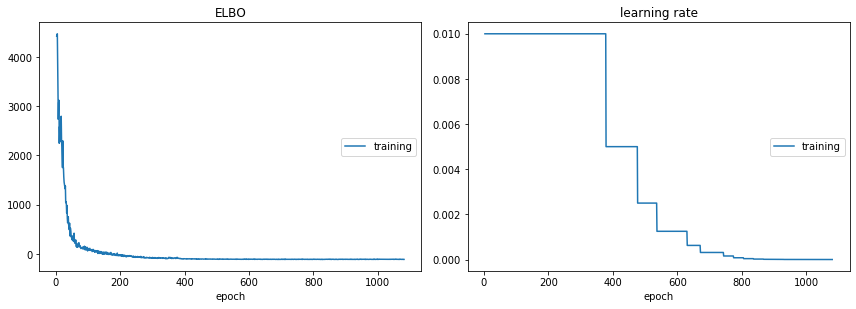

ELBO:
training   (min: -115.643, max: 8433.152, cur: -113.955)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.000)


In [23]:
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    VAE_optimizer.zero_grad()

    Div = KLDivGauss(VAE.mfvar.mu,VAE.mfvar.sigma)
    
    LL=torch.Tensor(n_samples_VAR)
    for i in range(n_samples_VAR):
        theta = VAE()
        LL[i]=loglikelihood(theta,x_data, y_data)
    L = Div - LL.mean()
    
    
    L.backward()
    

    learning_rate = VAE_optimizer.param_groups[0]['lr']

    VAE_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    #logs['memory'] = torch.cuda.memory_allocated(device=device)
    #logs['predictive likelihood'] = LL.detach().clone().cpu().numpy()
    liveloss.update(logs)

    if t % 10 == 0:
        liveloss.draw()

    #if t %2 == 0:
    VAE_optimizer.step()

    if learning_rate < 0.0000001:
        break

In [24]:
L

tensor(-112.7311, grad_fn=<SubBackward0>)

In [25]:
import matplotlib.pyplot as plt
L = VAE(10000).detach().numpy()

<IPython.core.display.Javascript object>


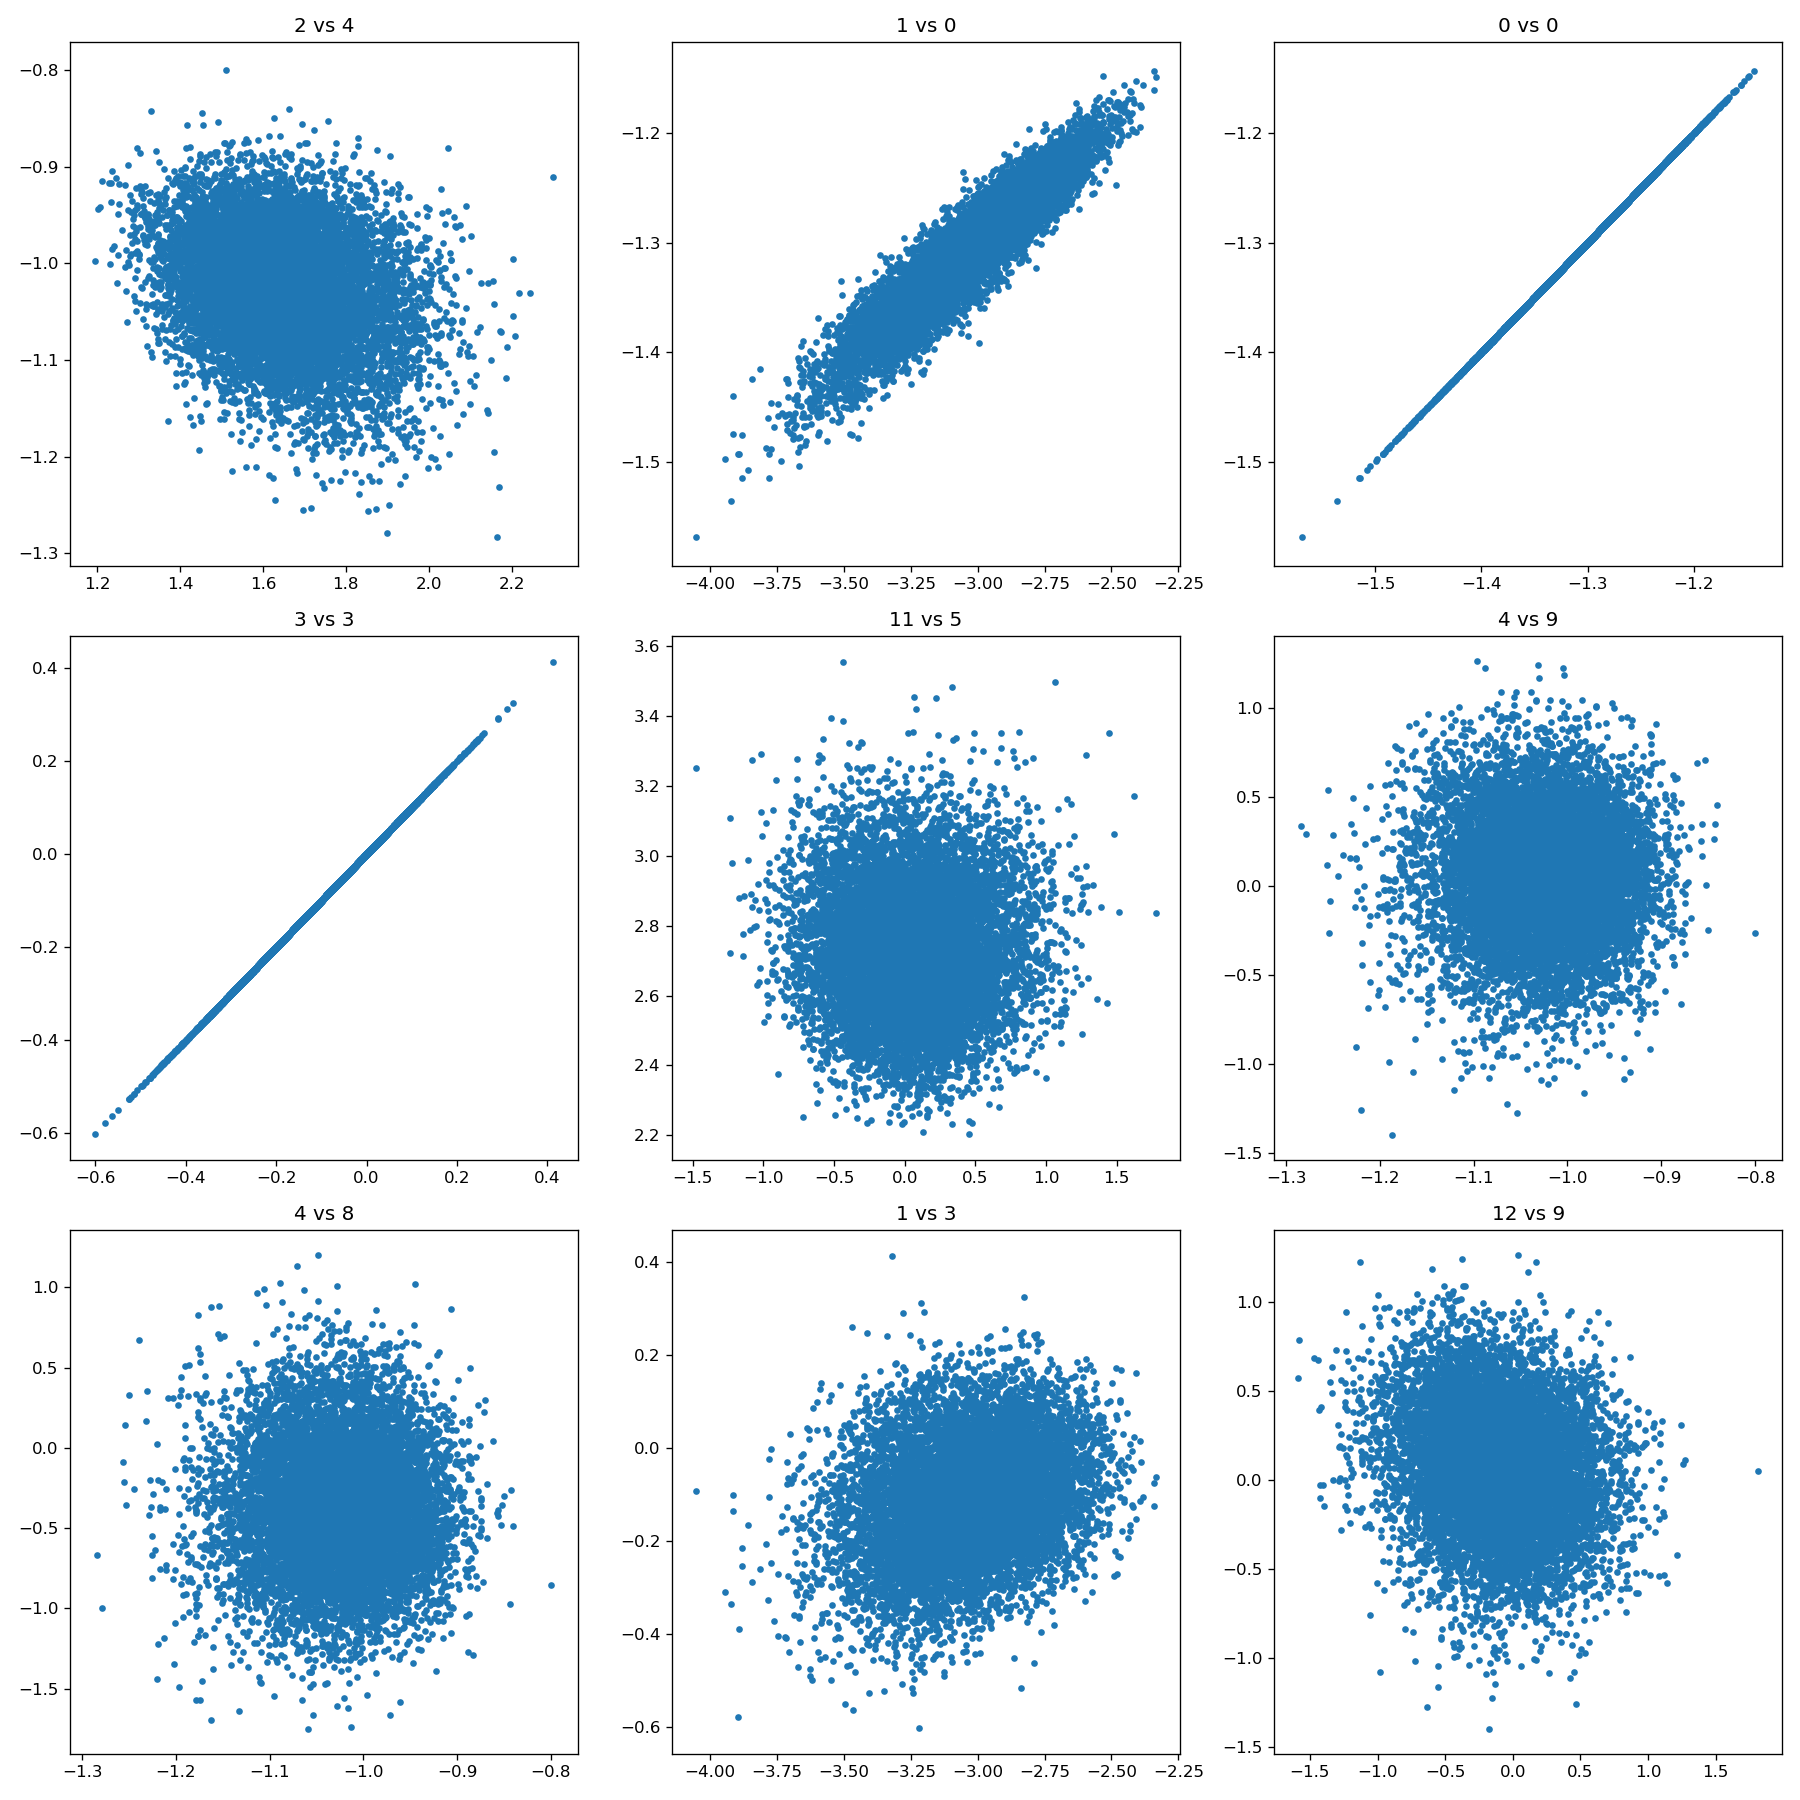

In [63]:
%matplotlib notebook

fig, axs = plt.subplots(3, 3,figsize=(15,15))
for k in range(3):
    for l in range(3):
        i=np.random.choice(param_count)
        j=np.random.choice(param_count)
        axs[k, l].scatter(L[:,i],L[:,j],marker='.')
        axs[k, l].set(title=str(i)+' vs '+str(j))
fig.tight_layout()

<IPython.core.display.Javascript object>


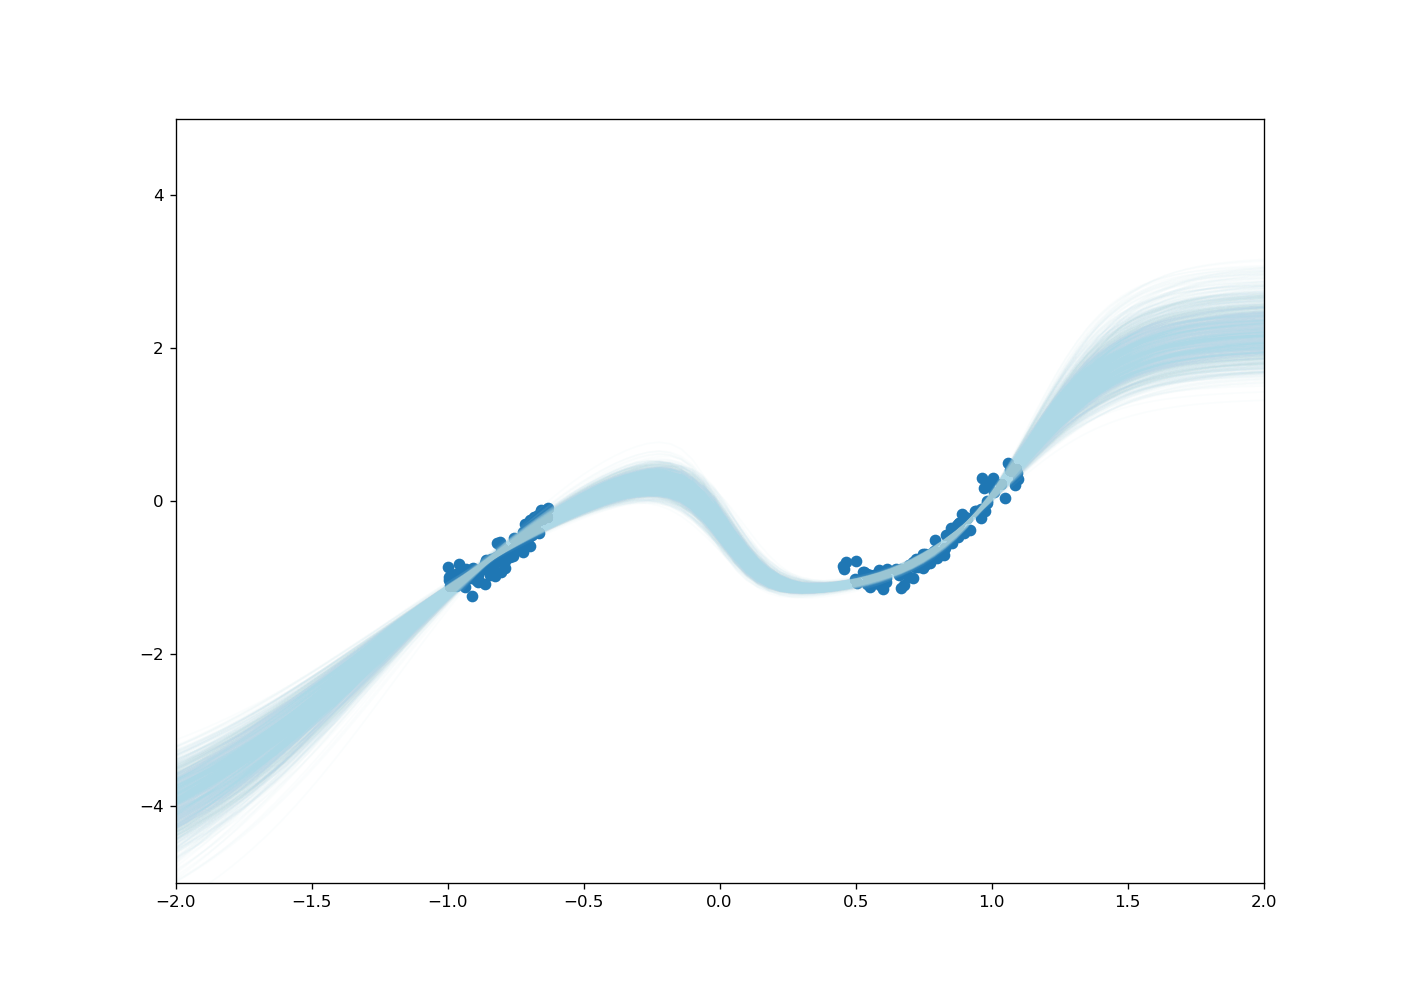

In [30]:
%matplotlib notebook
%matplotlib notebook


x_test = torch.linspace(-2.0,2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-5, 5) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    theta = VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [ ]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    latent =prior.sample()
    theta=VAE.decoder(latent)
    set_all_parameters(model, theta)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')